# Electron MVA Tutorial

Hello, good to see you again! This is the main part of the tutorial, where we inspect and understand the ntuples a bit, before finally training a few BTDs to separate real prompt electrons from fakes.

## Electron MVA Ntuple Data

In [ ]:
import getpass
import os
username = "rembserj"
if os.system('klist | grep Default | grep ' + username + '@CERN.CH'):
    os.system('echo %s' % getpass.getpass() + " | kinit " + username)

The uproot library is by far the most convinient library to load data from ROOT trees into pandas DataFrames or numpy arrays, which are the most common data structures in the scientific and ML Python ecosystem.

In [1]:
import uproot
import glob

In [6]:
root_files = glob.glob("/eos/user/r/rembserj/ntuples/electron_mva_run3/*.root")

Load the rootfile you produced before and get the ROOT file directory structure by callling `allkeys`:

In [7]:
f = uproot.open(root_files[0])
f.allkeys()

[b'ntuplizer;1', b'ntuplizer/tree;1']

There we go, the TTree with the electron data we seek must be `ntuplizer/tree`! Like in C++ ROOT, ignore the semicolon and the numbers after it in the names.

In [8]:
import pandas as pd
from tqdm import tqdm

In [9]:
unneccesary_columns = ['ele_index',
       'Spring16GPV1Vals', 'Spring16GPV1RawVals', 'Spring16HZZV1Vals',
       'Spring16HZZV1RawVals', 'Fall17NoIsoV2Vals',
       'Fall17IsoV2Vals', 'Fall17IsoV1Vals',
       'Fall17NoIsoV1Vals', 'Spring16GPV1wp80', 'Spring16GPV1wp90',
       'Spring16HZZV1wpLoose', 'Fall17noIsoV2wp80', 'Fall17noIsoV2wpLoose',
       'Fall17noIsoV2wp90', 'Fall17isoV2wpHZZ', 'Fall17isoV2wp80',
       'Fall17isoV2wpLoose', 'Fall17isoV2wp90', 'Fall17noIsoV1wp90',
       'Fall17noIsoV1wp80', 'Fall17noIsoV1wpLoose', 'Fall17isoV1wp90',
       'Fall17isoV1wp80', 'Fall17isoV1wpLoose', 'nEvent', 'nRun', 'nLumi']

def get_df(root_file_name):
    f = uproot.open(root_file_name)
    if len(f.allkeys()) == 0:
        return pd.DataFrame()
    df = uproot.open(root_file_name)["ntuplizer/tree"].pandas.df()
    return df.drop(unneccesary_columns, axis=1)

df = pd.concat((get_df(f) for f in  tqdm(root_files)), ignore_index=True)

100%|██████████| 76/76 [00:06<00:00, 12.05it/s]


Let's check what columns we have in this data (or "branches" if you come from ROOT):

In [10]:
df.columns

Index(['genNpu', 'vtxN', 'ele_q', 'ele_3q', 'matchedToGenEle', 'rho', 'ele_pt',
       'ele_oldsigmaietaieta', 'ele_oldsigmaiphiiphi', 'ele_oldcircularity',
       'ele_oldr9', 'ele_scletawidth', 'ele_sclphiwidth', 'ele_hadronicOverEm',
       'ele_oldhe', 'ele_kfhits', 'ele_kfchi2', 'ele_gsfchi2', 'ele_fbrem',
       'ele_gsfhits', 'ele_expected_inner_hits',
       'ele_conversionVertexFitProbability', 'ele_ep', 'ele_eelepout',
       'ele_IoEmIop', 'ele_deltaetain', 'ele_deltaphiin', 'ele_deltaetaseed',
       'ele_psEoverEraw', 'ele_pfPhotonIso', 'ele_pfChargedHadIso',
       'ele_pfNeutralHadIso', 'scl_E', 'scl_Et', 'scl_eta', 'scl_phi',
       'ele_sclRawE', 'ele_sclNclus', 'ele_olde15', 'ele_olde25max',
       'ele_olde55', 'ele_ecalE', 'ele_ecalErr', 'ele_trackErr', 'ele_combErr',
       'ele_PFcombErr', 'ele_pfSumPUIso', 'ele_SCfbrem', 'ele_eClass',
       'ele_nbrem', 'ele_oldhebc', 'ele_hebc', 'ele_isEB', 'ele_isEE',
       'ele_isEBEtaGap', 'ele_isEBPhiGap', 'ele_isEBEEGap',

That's a lot of information! Let's not try to understand everything at one, but explain when needed.

## Categorizing Electrons as Signal or Background

To say it once more: signal will be reconstructed electrons that match to a true prompt electron, while the background will be all unmatched and non-prompt electrons. Electrons from tau decays should be ignored.

The electron ntuplizer stores the category to which the electron belongs in the `matchedToGenEle` branch, and you can check the [ntuplizer source code](https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/plugins/ElectronMVANtuplizer.cc#L139) to learn which number corresponds to which category (starting from `UNMATCHED = 0`).

The electrons from taus correspond to `matchedToGenEle = 2`, so let's drop them from the data frame.

In [11]:
df = df[df["matchedToGenEle"] != 2]

Also we don't care about the distinction between non-prompt and unmatched electrons, so let's set both categories to the value zeros.

In [12]:
df.loc[df["matchedToGenEle"] != 1, "matchedToGenEle"] = 0

Very good, now `matchedToGenEle = 1` corresponds to signal and `matchedToGenEle = 0` to background.

In [13]:
df = df[df["scl_eta"].abs() < 2.5]

In [14]:
df = df.query("ele_pt >= 10")

Let's take a look at the $p_T$ and $\eta$ distributions to see if they look as expected:

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def get_label(name):
    if name == 0:
        return "background"
    else:
        return "signal"

def plot_electrons(df, column, bins, logscale=False, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    for name, group in df.groupby("matchedToGenEle"):
        group[column].hist(bins=bins, histtype="step", label=get_label(name), ax=ax, density=True)
    ax.set_ylabel("density")
    ax.set_xlabel(column)
    ax.legend()
    ax.set_title(title)
    if logscale:
        ax.set_yscale("log", nonposy='clip')

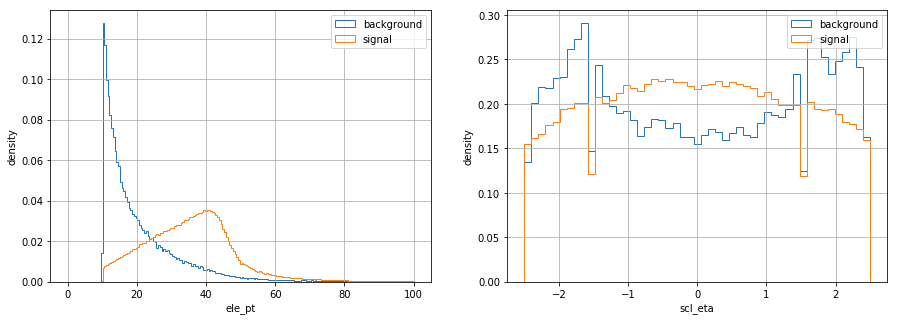

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df, "ele_pt", np.linspace(0, 100, 200), ax=axes[0])
plot_electrons(df, "scl_eta", np.linspace(-2.5, 2.5, 50), ax=axes[1])
plt.show()

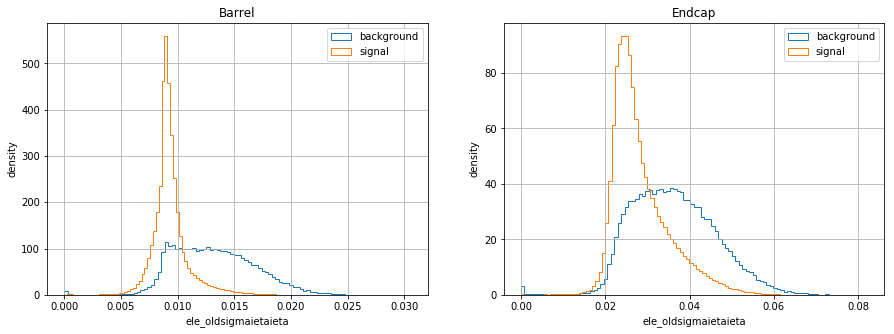

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df.query("ele_isEB"), "ele_oldsigmaietaieta", 100, ax=axes[0], title="Barrel")
plot_electrons(df.query("ele_isEE"), "ele_oldsigmaietaieta", 100, ax=axes[1], title="Endcap")
plt.show()

## Training the Boosted Decision Tree Classifiers

In [18]:
features_barrel = ["ele_oldsigmaietaieta", "ele_oldsigmaiphiiphi",
            "ele_oldcircularity", "ele_oldr9", "ele_scletawidth",
            "ele_sclphiwidth", "ele_oldhe", "ele_kfhits", "ele_kfchi2",
            "ele_gsfchi2", "ele_fbrem", "ele_gsfhits",
            "ele_expected_inner_hits", "ele_conversionVertexFitProbability",
            "ele_ep", "ele_eelepout", "ele_IoEmIop", "ele_deltaetain",
            "ele_deltaphiin", "ele_deltaetaseed", "rho",
            "ele_pfPhotonIso", "ele_pfChargedHadIso", "ele_pfNeutralHadIso"]
            
features_endcap = features_barrel + ["ele_psEoverEraw"]

In [19]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [20]:
import xgboost2tmva

In [21]:
xgboost_params = {'eval_metric':'auc',
                  'max_depth' : 4,
                  'objective'  :'binary:logitraw'}

In [22]:
category_titles = ["EB1_5", "EB2_5", "EE_5", "EB1_10", "EB2_10", "EE_10"]

In [23]:
for i, group_df in df.groupby("EleMVACats"):
    
    if i < 3:
        continue

    category = category_titles[i]
    
    features = features_endcap if "EE" in category else features_barrel
    
    X = group_df[features]
    y = group_df["matchedToGenEle"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    idx_train = X_train.index
    idx_test = X_test.index

    dmatrix_train = xgb.DMatrix(X_train.copy(), label=np.copy(y_train))
    dmatrix_test  = xgb.DMatrix(X_test.copy(), label=np.copy(y_test ))

    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)

    print(category + ":")
    print("training on {0} signal and {1} background electrons".format(n_pos, n_neg))

    xgboost_params["scale_pos_weight"] = 1. * n_neg / n_pos
    model = xgb.train(xgboost_params, dmatrix_train, num_boost_round=1000,
                      evals= [(dmatrix_train, 'train'),
                               (dmatrix_test, 'test')],
                      early_stopping_rounds=10,
                      verbose_eval=False)
    
    print("early stopping after {0} boosting rounds".format(model.best_iteration))
    print("")
    
    xgboost2tmva.convert_model(model.get_dump(),
                               input_variables=[(f,'F') for f in features],
                               output_xml='electron_id_{0}.xml'.format(i))
    
    model.save_model("electron_id_{0}.bin".format(i))

    df.loc[idx_train, "score"] = model.predict(dmatrix_train)
    df.loc[idx_test, "score"] = model.predict(dmatrix_test)
    
    df.loc[idx_train, "test"] = False
    df.loc[idx_test, "test"] = True

EB1_10:
training on 188079 signal and 19516 background electrons
early stopping after 127 boosting rounds

EB2_10:
training on 150655 signal and 19291 background electrons
early stopping after 101 boosting rounds

EE_10:
training on 190827 signal and 33653 background electrons
early stopping after 183 boosting rounds



In [24]:
from sklearn import metrics

def plot_roc_curve(df, score_column, tpr_threshold=0.7, ax=None, color=None, linestyle='-', label=None):
    if ax is None:
        ax = plt.gca()
    if label is None:
        label = score_column
    fpr, tpr, thresholds = metrics.roc_curve(df["matchedToGenEle"], df[score_column])
    mask = tpr > tpr_threshold
    fpr, tpr = fpr[mask], tpr[mask]
    ax.semilogy(tpr, fpr, label=label, color=color, linestyle=linestyle)

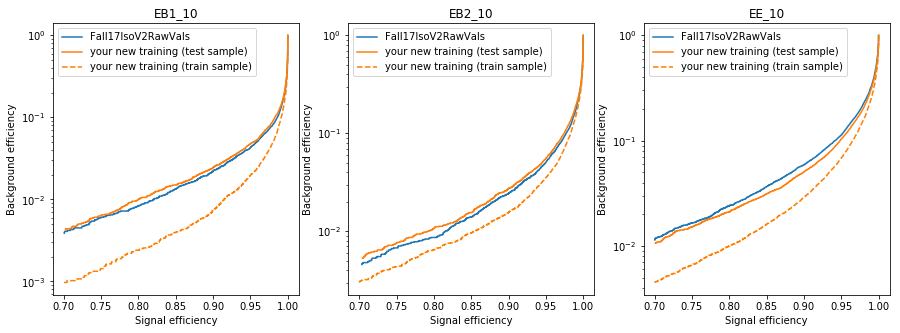

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, df_group in df.groupby("EleMVACats"):
    
    if i < 3:
        continue
    
    df_train = df_group.query("not test")
    df_test = df_group.query("test")
    
    
    ax = axes[i%3]
    plot_roc_curve(df_test, "Fall17IsoV2RawVals", ax=ax)
    plot_roc_curve(df_test, "score", ax=ax, label="your new training (test sample)")
    plot_roc_curve(df_train, "score", ax=ax, color="#ff7f02", linestyle='--', label="your new training (train sample)")
    ax.set_title(category_titles[i])
    ax.legend()
    ax.set_xlabel("Signal efficiency")
    ax.set_ylabel("Background efficiency")
    
plt.show()